In [1]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error, r2_score

加载数据，原数据根据时间分为了两部分，这里直接将较长的数据作为测试集，较短的作为测试集

In [2]:
# Load Data
csv1 = pd.read_csv("1mayo - agosto 2021.csv",quoting=csv.QUOTE_NONE)
csv2 = pd.read_csv("2agosto -dic 2021.csv",quoting=csv.QUOTE_NONE)

train = csv1.copy()
test = csv2.copy()

![alt text](info_ch.png)

对于数据进行预处理，删除数据中自带的引号，去除无用列，转变数据类型

In [3]:
#Data Preprocessing
def data_preprocessing(df):

    #Drop Quotation Marks in the whole dataframe
    df.columns = df.columns.str.replace('"','')
    df.replace({r'"': ''}, regex=True, inplace=True)

    # Drop unnecessary columns
    df = df.drop(['MAC','fecha_servidor'],axis=1)
    
    #Change data type
    df['fecha_esp32'] = pd.to_datetime(df['fecha_esp32'], format='%Y-%m-%d %H:%M:%S')
    df[["voltaje","corriente","potencia","frecuencia","energia","fp","ESP32_temp","WORKSTATION_CPU",
        "WORKSTATION_CPU_POWER","WORKSTATION_CPU_TEMP","WORKSTATION_GPU","WORKSTATION_GPU_POWER","WORKSTATION_GPU_TEMP",
        "WORKSTATION_RAM","WORKSTATION_RAM_POWER"]]=df[["voltaje","corriente","potencia","frecuencia","energia","fp","ESP32_temp","WORKSTATION_CPU",
        "WORKSTATION_CPU_POWER","WORKSTATION_CPU_TEMP","WORKSTATION_GPU","WORKSTATION_GPU_POWER","WORKSTATION_GPU_TEMP",
        "WORKSTATION_RAM","WORKSTATION_RAM_POWER"]].astype(float)
    df['weekday']=df['weekday'].astype(int)
    
    
    return df

train = data_preprocessing(train)
test = data_preprocessing(test)

根据EDA中可知，数据中相当一部分是空载的数据，将其与运作时的数据进行区分

In [4]:
#Split the dataframe into sleeping part and working part
sleeping_df_train = train[train['WORKSTATION_CPU_POWER'] == 0]
working_df_train = train[train['WORKSTATION_CPU_POWER'] != 0]
sleeping_df_test = test[test['WORKSTATION_CPU_POWER'] == 0]
working_df_test = test[test['WORKSTATION_CPU_POWER'] != 0]

working_df_train.head()

,weekday,fecha_esp32,voltaje,corriente,potencia,frecuencia,energia,fp,ESP32_temp,WORKSTATION_CPU,WORKSTATION_CPU_POWER,WORKSTATION_CPU_TEMP,WORKSTATION_GPU,WORKSTATION_GPU_POWER,WORKSTATION_GPU_TEMP,WORKSTATION_RAM,WORKSTATION_RAM_POWER
4145154,4,2021-06-10 02:13:04,119.9,1.14,125.1,59.9,81.89,0.92,33.89,11.28,36.71,33.0,1.0,35.0,15.00,32.29,6.97
4145155,4,2021-06-10 02:13:05,120.0,1.04,113.3,59.9,81.89,0.91,33.89,11.28,36.71,33.0,1.0,35.0,15.00,32.29,6.97
4145156,4,2021-06-10 02:13:06,119.9,1.17,128.4,60.0,81.89,0.92,33.89,11.28,36.71,33.0,1.0,35.0,15.00,32.29,6.97
4145157,4,2021-06-10 02:13:07,119.9,1.17,128.4,60.0,81.89,0.92,33.89,13.67,36.36,36.0,2.0,35.0,14.51,32.45,10.16
4145158,4,2021-06-10 02:13:08,120.0,1.08,117.9,60.0,81.89,0.91,33.89,13.67,36.36,36.0,2.0,35.0,14.51,32.45,10.16


![alt text](PUE.png)

https://en.wikipedia.org/wiki/Power_usage_effectiveness

构建计算PUE所需的属性

In [5]:
#Feature Engineering
def feature_engineering(df):
    
    df['Total_Workstation_Power'] = df['WORKSTATION_CPU_POWER'] + df['WORKSTATION_GPU_POWER'] + df['WORKSTATION_RAM_POWER']
    df['PUE'] = df['potencia'] / df['Total_Workstation_Power']

    df['Temp_Gradient'] = df['WORKSTATION_CPU_POWER']-df['ESP32_temp']
    df['Temp_load'] = df['WORKSTATION_CPU']*df['WORKSTATION_CPU_POWER']

    return df

working_df_train = feature_engineering(working_df_train)
working_df_test = feature_engineering(working_df_test)

working_df_train.head()

C:\Users\virvi\AppData\Local\Temp\ipykernel_10712\2128035859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total_Workstation_Power'] = df['WORKSTATION_CPU_POWER'] + df['WORKSTATION_GPU_POWER'] + df['WORKSTATION_RAM_POWER']
C:\Users\virvi\AppData\Local\Temp\ipykernel_10712\2128035859.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PUE'] = df['potencia'] / df['Total_Workstation_Power']
C:\Users\virvi\AppData\Local\Temp\ipykernel_10712\2128035859.py:7: SettingWithCopyWarning: 
A value is tryi

,weekday,fecha_esp32,voltaje,corriente,potencia,frecuencia,energia,fp,ESP32_temp,WORKSTATION_CPU,...,WORKSTATION_CPU_TEMP,WORKSTATION_GPU,WORKSTATION_GPU_POWER,WORKSTATION_GPU_TEMP,WORKSTATION_RAM,WORKSTATION_RAM_POWER,Total_Workstation_Power,PUE,Temp_Gradient,Temp_load
4145154,4,2021-06-10 02:13:04,119.9,1.14,125.1,59.9,81.89,0.92,33.89,11.28,...,33.0,1.0,35.0,15.00,32.29,6.97,78.68,1.589985,2.82,414.0888
4145155,4,2021-06-10 02:13:05,120.0,1.04,113.3,59.9,81.89,0.91,33.89,11.28,...,33.0,1.0,35.0,15.00,32.29,6.97,78.68,1.440010,2.82,414.0888
4145156,4,2021-06-10 02:13:06,119.9,1.17,128.4,60.0,81.89,0.92,33.89,11.28,...,33.0,1.0,35.0,15.00,32.29,6.97,78.68,1.631927,2.82,414.0888
4145157,4,2021-06-10 02:13:07,119.9,1.17,128.4,60.0,81.89,0.92,33.89,13.67,...,36.0,2.0,35.0,14.51,32.45,10.16,81.52,1.575074,2.47,497.0412
4145158,4,2021-06-10 02:13:08,120.0,1.08,117.9,60.0,81.89,0.91,33.89,13.67,...,36.0,2.0,35.0,14.51,32.45,10.16,81.52,1.446271,2.47,497.0412


确定训练所用的属性与目标

In [6]:
# Features and Target variable
y = working_df_train['PUE']
X = working_df_train.drop(['PUE','fecha_esp32','potencia','energia','Total_Workstation_Power','WORKSTATION_CPU_POWER','WORKSTATION_GPU_POWER','WORKSTATION_RAM_POWER'], axis=1)
y_test = working_df_test['PUE']
X_test = working_df_test.drop(['PUE','fecha_esp32','potencia','energia','Total_Workstation_Power','WORKSTATION_CPU_POWER','WORKSTATION_GPU_POWER','WORKSTATION_RAM_POWER'], axis=1)

In [7]:
#Transform the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

指定模型参数

In [8]:
lgb_params = {
    'objective': 'regression', 
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

In [9]:
rm_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

训练模型并预测

In [10]:
model_lgb = lgb.LGBMRegressor(**lgb_params, n_estimators=1000)
model_lgb.fit(X, y)
y_pred_lgb = model_lgb.predict(X_test)

In [11]:
model_rm = RandomForestRegressor(**rm_params)
model_rm.fit(X, y)
y_pred_rm = model_rm.predict(X_test)

交叉验证（可以先略过）

In [12]:
#Cross Validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_predictions = np.zeros(X.shape[0])
test_predictions = np.zeros(X_test.shape[0])
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}/{n_folds}...")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = lgb.LGBMRegressor(**lgb_params, n_estimators=1000)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100),
        ],
    )
    
    oof_predictions[val_index] = model.predict(X_val)
    test_predictions += model.predict(X_test) / n_folds



Training fold 1/5...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.0157784
[200]	valid_0's rmse: 0.0148328
[300]	valid_0's rmse: 0.0145519
[400]	valid_0's rmse: 0.0144053
[500]	valid_0's rmse: 0.0143068
[600]	valid_0's rmse: 0.0142373
[700]	valid_0's rmse: 0.0141783
[800]	valid_0's rmse: 0.0141251
[900]	valid_0's rmse: 0.01408
[1000]	valid_0's rmse: 0.0140376
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0140376
Training fold 2/5...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.0157928
[200]	valid_0's rmse: 0.0148103
[300]	valid_0's rmse: 0.0145164
[400]	valid_0's rmse: 0.0143728
[500]	valid_0's rmse: 0.0142707
[600]	valid_0's rmse: 0.0141961
[700]	valid_0's rmse: 0.0141352
[800]	valid_0's rmse: 0.0140745
[900]	valid_0's rmse: 0.0140163
[1000]	valid_0's rmse: 0.0139693
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0139693
Training fold 3/5...
Training unti

与源数据对比，展示模型精确度

In [13]:
#Accuracy of the models
rmse_lgb = root_mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
rmse_rm = root_mean_squared_error(y_test, y_pred_rm)
r2_rm = r2_score(y_test, y_pred_rm)
rmse_cv = root_mean_squared_error(y_test, test_predictions)
r2_cv = r2_score(y_test, test_predictions)
print(f"Lgb RMSE: {rmse_lgb}")
print(f"Lgb R2: {r2_lgb}")
print(f"Rm RMSE: {rmse_rm}")
print(f"Rm R2: {r2_rm}")
print(f"OOF CV RMSE: {rmse_cv}")
print(f"OOF CV R2: {r2_cv}")


Lgb RMSE: 0.05145565204592751
Lgb R2: 0.8814092399219245
Rm RMSE: 0.07514497441869944
Rm R2: 0.7470791908453526
OOF CV RMSE: 0.049537973768371144
OOF CV R2: 0.890083938511465


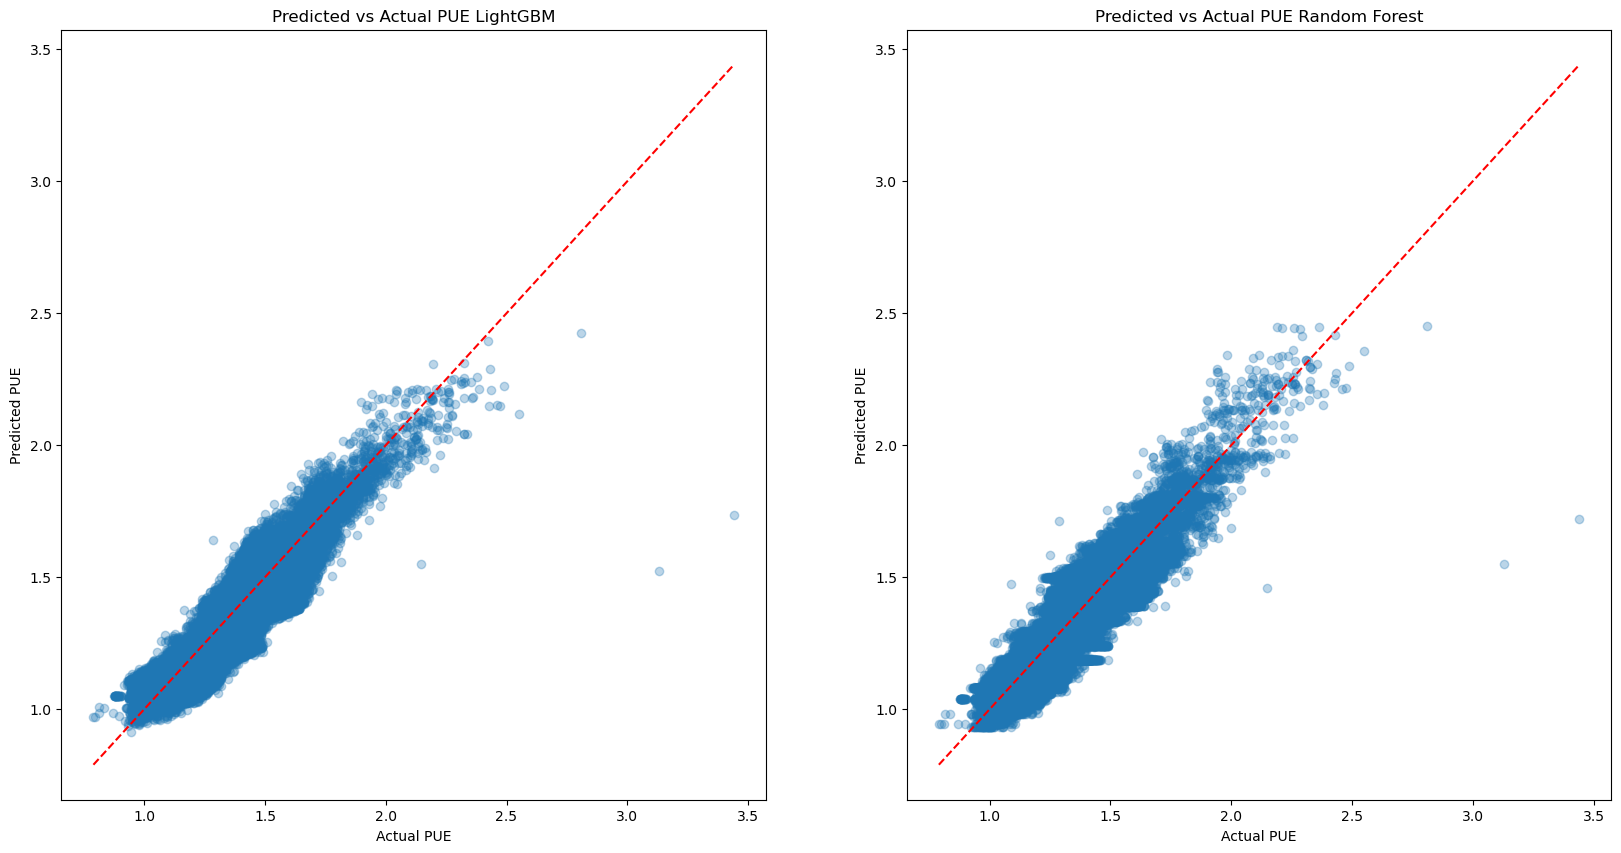

In [14]:
#Compare two models: without CV and with CV 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.scatter(y_test, y_pred_lgb, alpha=0.3)
ax1.set_xlabel('Actual PUE')
ax1.set_ylabel('Predicted PUE')
ax1.set_title('Predicted vs Actual PUE LightGBM')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.scatter(y_test, y_pred_rm, alpha=0.3)
ax2.set_xlabel('Actual PUE')
ax2.set_ylabel('Predicted PUE')
ax2.set_title('Predicted vs Actual PUE Random Forest')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show() 

